# TensorFlow Tutorial for Policy Gradients
> Deep RL course - Fall 2024 - Sharif University of Technology - Workshop session <br>
> Author: M Narimani - December 8th, 2024

In [1]:
import tensorflow as tf
import numpy as np

## Basic Tensor Operations

In [2]:
# Creating tensors
x = tf.constant([1.0, 2.0, 3.0])
y = tf.constant([4.0, 5.0, 6.0])

print("x:", x.numpy())
print("y:", y.numpy())
print("\nBasic operations:")
print("Addition:", (x + y).numpy())
print("Multiplication:", (x * y).numpy())
print("Mean of x:", tf.reduce_mean(x).numpy())

x: [1. 2. 3.]
y: [4. 5. 6.]

Basic operations:
Addition: [5. 7. 9.]
Multiplication: [ 4. 10. 18.]
Mean of x: 2.0


In [3]:
# Matrix operations
A = tf.constant([[1.0, 2.0], [3.0, 4.0]])
b = tf.constant([[5.0], [6.0]])

print("Matrix multiplication:")
print("\nA:")
print(A.numpy())
print("\nb:")
print(b.numpy())
print("\nA @ b:")
print((A @ b).numpy())

Matrix multiplication:

A:
[[1. 2.]
 [3. 4.]]

b:
[[5.]
 [6.]]

A @ b:
[[17.]
 [39.]]


## Probability Operations

In [4]:
# Logits (raw/non-normalized predictions) to probabilities
logits = tf.constant([2.0, 1.0, 0.5])
probs = tf.nn.softmax(logits)
print("Logits:", logits.numpy())
print("Probabilities (softmax):", probs.numpy())

Logits: [2.  1.  0.5]
Probabilities (softmax): [0.6285317  0.23122393 0.14024438]


In [5]:
# Log probabilities
log_probs = tf.math.log(probs)
print("Log probabilities:", log_probs.numpy())

Log probabilities: [-0.46436882 -1.4643687  -1.9643688 ]


## Automatic Differentiation

In [6]:
# Simple gradient example
x = tf.Variable(2.0)
with tf.GradientTape() as tape:
    y = x * x
grad = tape.gradient(y, x)
print("dy/dx at x=2:", grad.numpy())

dy/dx at x=2: 4.0


In [7]:
# Multiple variables and operations
x1 = tf.Variable(2.0)
x2 = tf.Variable(3.0)
with tf.GradientTape() as tape:
    y = x1 * x2 + tf.square(x1)
grads = tape.gradient(y, [x1, x2])
print("Gradients for x1 and x2:", [g.numpy() for g in grads])

Gradients for x1 and x2: [7.0, 2.0]


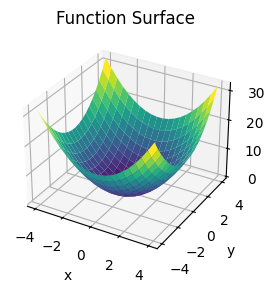

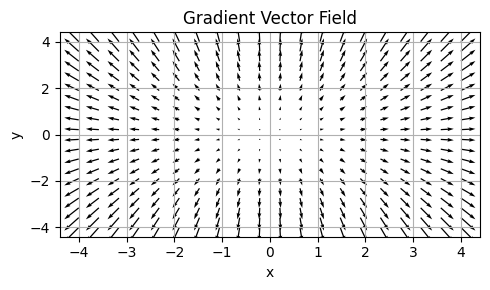

In [8]:
import matplotlib.pyplot as plt

# Create a grid of points
x = np.linspace(-4, 4, 20)
y = np.linspace(-4, 4, 20)
X, Y = np.meshgrid(x, y)

# Convert to TensorFlow Variables
x_tf = tf.Variable(X)
y_tf = tf.Variable(Y)

# Compute gradients of z = x² + y²
# TODO: Missing 2 lines of code to calculate the gradient

# TODO: calculate `grads`

# Visualization
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, z.numpy(), cmap='viridis')
ax.set_title('Function Surface')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

# Gradient vector field
plt.figure(figsize=(5, 3))
plt.quiver(X, Y, grads[0].numpy(), grads[1].numpy())
plt.title('Gradient Vector Field')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.tight_layout()
plt.show()

# Policy gradient precess
## Policy network

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(8, activation='relu', input_shape=(4,)),
    tf.keras.layers.Dense(2, activation='softmax')
])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 40        
                                                                 
 dense_1 (Dense)             (None, 2)                 18        
                                                                 
Total params: 58
Trainable params: 58
Non-trainable params: 0
_________________________________________________________________


## Data Collection Phase

In [10]:
def simulate_cartpole_state():
    return np.random.randn(4)  # [cart_position, cart_velocity, pole_angle, pole_velocity]

In [11]:
n_steps = 3

states = []
actions = []
raw_probs = []

for step in range(n_steps):
    state = simulate_cartpole_state()
    states.append(state)
    
    # Get action probabilities
    state_input = np.array([state])
    action_probs = model(state_input).numpy().flatten()
    raw_probs.append(action_probs)
    
    # Sample action
    action = np.random.choice(2, p=action_probs)
    actions.append(action)
    
    print(f"\nStep {step + 1}:")
    print(f"State: {state}")
    print(f"Action probabilities: [left={action_probs[0]:.2f}, right={action_probs[1]:.2f}]")
    print(f"Chosen action: {'left' if action == 0 else 'right'}")


Step 1:
State: [-1.44336753e-03  5.32983947e-01  1.50879204e+00  4.27222313e-01]
Action probabilities: [left=0.44, right=0.56]
Chosen action: left

Step 2:
State: [ 1.26345088 -0.21504838  0.07096212 -0.69352184]
Action probabilities: [left=0.31, right=0.69]
Chosen action: left

Step 3:
State: [ 0.82661631 -1.26639339  0.89900847 -0.5069331 ]
Action probabilities: [left=0.41, right=0.59]
Chosen action: right


## Reward Processing

In [12]:
def discount_rewards(rewards, gamma=0.99):
    """Calculate discounted rewards"""
    discounted = np.zeros_like(rewards, dtype=np.float32)
    running_sum = 0
    for t in reversed(range(len(rewards))):
        running_sum = running_sum * gamma + rewards[t]
        discounted[t] = running_sum
    return discounted

In [13]:
# Example rewards
raw_rewards = [1.0, 1.0, 1.0]
discounted_rewards = discount_rewards(raw_rewards)

print("Raw rewards:", raw_rewards)
print("Discounted rewards:", discounted_rewards)

Raw rewards: [1.0, 1.0, 1.0]
Discounted rewards: [2.9701 1.99   1.    ]


## Policy Update

In [14]:
states = np.array(states)
actions = np.array(actions)

# Create action indices
idx = np.array(list(zip(range(len(actions)), actions)))
print("Action indices (idx):")
print(idx)
print("\nEach row is (timestep, action_taken)")

Action indices (idx):
[[0 0]
 [1 0]
 [2 1]]

Each row is (timestep, action_taken)


In [15]:
# Policy gradient update
with tf.GradientTape() as tape:
    # Get action probabilities for all states
    action_probs = model(states)
    
    # Select probabilities of actions that were taken
    selected_probs = tf.gather_nd(action_probs, idx) #gather_nd returnes the elements of action_probs corresponding to indices of idx
    print("\nProbabilities of selected actions:", selected_probs.numpy())
    
    # Calculate log probabilities
    log_probs = tf.math.log(selected_probs)
    print("Log probabilities:", log_probs.numpy())
    
    # Calculate loss
    loss = -tf.reduce_mean(log_probs * discounted_rewards)
    print("\nPolicy gradient loss:", loss.numpy())

# Get gradients
gradients = tape.gradient(loss, model.trainable_variables)
print("\nGradient shapes:", [g.shape for g in gradients])


Probabilities of selected actions: [0.44009104 0.3126839  0.59458035]
Log probabilities: [-0.82077366 -1.1625625  -0.5198994 ]

Policy gradient loss: 1.7570596

Gradient shapes: [TensorShape([4, 8]), TensorShape([8]), TensorShape([8, 2]), TensorShape([2])]


> **TODO:** Justify "Gradient shapes" by calling `model.summary()`

## REINFORCE with Baseline

In [16]:
# Create a simple value network
baseline = tf.keras.Sequential([
    tf.keras.layers.Dense(8, activation='relu', input_shape=(4,)),
    tf.keras.layers.Dense(1)
])

# Predict values
values = baseline(states)
print("Predicted values:", values.numpy().flatten())

# Calculate advantages
advantages = discounted_rewards - values.numpy().flatten()
print("Advantages:", advantages)

# Demonstrate policy update with advantages
with tf.GradientTape() as tape:
    action_probs = model(states)
    selected_probs = tf.gather_nd(action_probs, idx)
    log_probs = tf.math.log(selected_probs)
    
    # Use advantages instead of raw rewards
    loss = -tf.reduce_mean(log_probs * advantages)
    print("\nPolicy gradient loss with advantages:", loss.numpy())

Predicted values: [ 0.22082894 -0.5578478  -1.5035274 ]
Advantages: [2.749271  2.5478477 2.5035274]

Policy gradient loss with advantages: 2.173381
